In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from desc import set_device
set_device("gpu")

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
from desc.backend import jax
jax.devices("gpu")

[CudaDevice(id=0)]

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.14.1+371.g6a626f49a.
Using JAX backend: jax version=0.5.0, jaxlib version=0.5.0, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.81 GB available memory.


In [ ]:
from test_utils import *

eq = desc.io.load("Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-init.h5")
for i in [4,6,8,10]:
    eq2 = desc.io.load(f"Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-island-LMN{i}.h5")
    Rr1, Zr1, Rv1, Zv1 = compute_coords(eq)
    Rr2, Zr2, Rv2, Zv2 = compute_coords(eq2)
    rho_err, theta_err = area_difference(Rr1, Rr2, Zr1, Zr2, Rv1, Rv2, Zv1, Zv2)

    print(f"res {i} : max_r_err {np.max(rho_err):.2e}, max_theta_err {np.max(theta_err):.2e}")
eq2 = desc.io.load("Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-island-resolved.h5")
Rr1, Zr1, Rv1, Zv1 = compute_coords(eq)
Rr2, Zr2, Rv2, Zv2 = compute_coords(eq2)
rho_err, theta_err = area_difference(Rr1, Rr2, Zr1, Zr2, Rv1, Rv2, Zv1, Zv2)

print(f"resolved : max_r_err {np.max(rho_err):.2e}, max_theta_err {np.max(theta_err):.2e}")

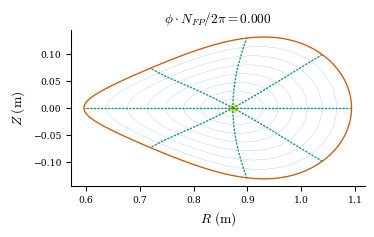

In [ ]:
eq2 = desc.io.load(
    f"Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-island-LMN4.h5"
)
eq1 = desc.io.load(
    f"Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-island-LMN10.h5"
)
eq0 = desc.io.load(
    f"Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-init.h5"
)
eq0_resolved = desc.io.load(f"Poincare/ISLAND STUFF/LANDREMAN2021/eq-org-landreman2021-island-resolved.h5")
plot_surfaces(eq2, phi=1, NR=30, NT=30000, rho_lw=0.1)
plt.savefig("poincare-high-res.png", dpi=2000)

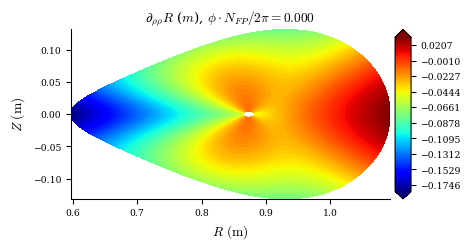

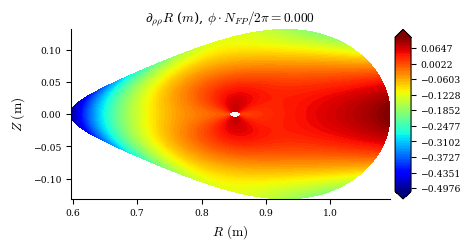

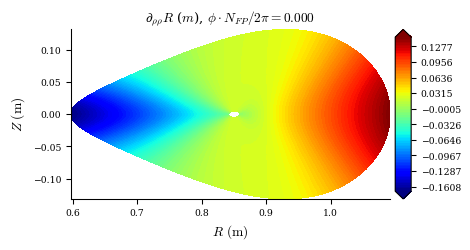

In [ ]:
plot_section(eq0, "R_rr", phi=1)
plot_section(eq2, "R_rr", phi=1)
plot_section(eq1, "R_rr", phi=1)

(<Figure size 480.095x480.095 with 2 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ ($N \\cdot m^{-3}$), $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

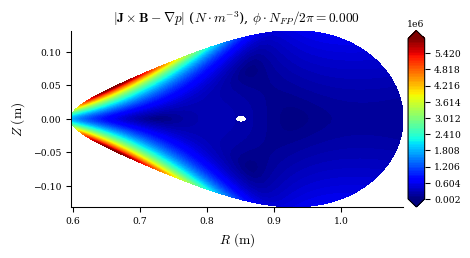

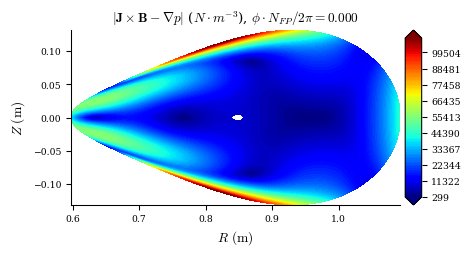

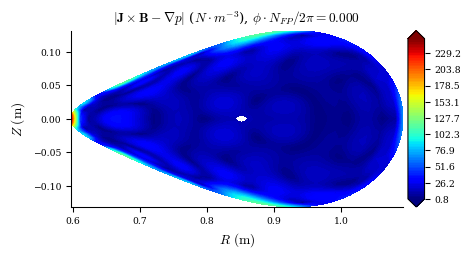

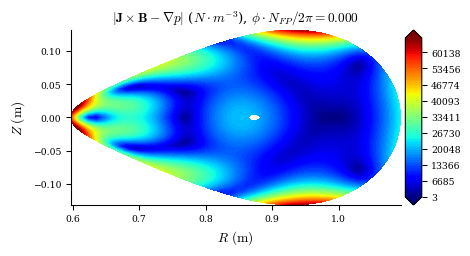

In [32]:
plot_section(eq0, "|F|", phi=1)
plot_section(eq0_resolved_2, "|F|", phi=1)
plot_section(eq1, "|F|", phi=1)
plot_section(eq2, "|F|", phi=1)

In [31]:
eq0_resolved_2 = eq0.copy()
eq0_resolved_2.set_initial_guess()
eq0_resolved_2.solve(ftol=1e-3, verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 683 ms
Timer: Objective build = 1.66 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 643 ms
Timer: LinearConstraintProjection build = 4.67 sec
Number of parameters: 71
Number of objectives: 544
Timer: Initializing the optimization = 7.05 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.121e+00                                    1.361e+00   
       1              2          5.643e-02      1.0

(Equilibrium at 0x7f5bf75eaf00 (L=3, M=3, N=4, NFP=2, sym=True, spectral_indexing=ansi, vacuum=True, profile='current'),
     message: Optimization terminated successfully.
              `ftol` condition satisfied. (ftol=1.00e-03)
     success: True
         fun: [-1.702e-04  1.119e-04 ... -1.997e-04  1.085e-04]
           x: [ 6.339e-02  3.745e-02 ...  1.882e-01 -1.181e-01]
         nit: 6
        cost: 0.0002151981356637641
           v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
  optimality: 6.680711778332721e-06
        nfev: 7
        njev: 7
        allx: [Array([-1.908e-17,  0.000e+00, ...,  0.000e+00,  2.984e-17],      dtype=float64), Array([ 1.256e-04,  0.000e+00, ...,  0.000e+00,  2.984e-17],      dtype=float64), Array([ 6.541e-05,  0.000e+00, ...,  0.000e+00,  2.984e-17],      dtype=float64), Array([ 2.988e-05,  0.000e+00, ...,  0.000e+00,  2.984e-17],      dtype=float64), Array([ 2.971e-05,  0.000e+00, ...,  0.000e+00,  2.984e-17],      dtype=float64), Array([ 2.970